In [ ]:
import pandas as pd
import os

# Read the complaints file using the existing data_path variable

data_path = 'supplementary/complaitns_for_anger.csv' # change this to the correct path
complaints = pd.read_csv(data_path)

# Display the first few rows of the file
complaints.head()

In [ ]:
# Convert the Excel file to a CSV file
# complaints.to_csv('Complaints.csv', index=False)

# print("Complaints.xlsx has been successfully converted to Complaints.csv")

Complaints.xlsx has been successfully converted to Complaints.csv


In [10]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
import numpy as np

def setup_local_model(model_name="deepseek-ai/deepseek-coder-1.3b-base", device="cuda"):
    """
    Load a smaller DeepSeek model locally.
    Falls back to CPU if CUDA is not available.
    """
    # Check if CUDA is available, otherwise use CPU
    if device == "cuda" and not torch.cuda.is_available():
        print("CUDA not available, switching to CPU")
        device = "cpu"
    
    print(f"Loading model {model_name} on {device}...")
    
    # Loading in 4-bit quantization to reduce memory usage
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        
        # For 4-bit quantization (requires bitsandbytes library)
        if device == "cuda":
            try:
                # Attempt to load with 4-bit quantization
                model = AutoModelForCausalLM.from_pretrained(
                    model_name,
                    torch_dtype=torch.float16,
                    load_in_4bit=True,
                    device_map="auto"
                )
                print("Model loaded with 4-bit quantization")
            except Exception as e:
                print(f"4-bit quantization failed: {e}")
                # Fall back to regular loading
                model = AutoModelForCausalLM.from_pretrained(
                    model_name,
                    torch_dtype=torch.float16,
                    device_map="auto"
                )
        else:
            # CPU loading (no quantization)
            model = AutoModelForCausalLM.from_pretrained(model_name)
            model.to(device)
    
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Trying alternative smaller model...")
        
        # Fallback to an even smaller model
        fallback_model = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
        tokenizer = AutoTokenizer.from_pretrained(fallback_model)
        model = AutoModelForCausalLM.from_pretrained(fallback_model)
        model.to(device)
    
    return model, tokenizer

def get_anger_score_local(complaint_text, model, tokenizer, device="cuda"):
    """
    Get anger score using a locally deployed model
    """
    # Create prompt for anger score analysis
    prompt = f"""
    Analyze the following customer complaint and rate it on an anger/frustration scale from 0 to 10, 
    where 0 is completely neutral/calm and 10 is extremely angry/frustrated.
    
    Only respond with a number between 0 and 10.
    
    Customer Complaint: {complaint_text}
    
    Anger Score:"""
    
    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    
    # Generate a response with the model
    with torch.no_grad():
        outputs = model.generate(
            inputs["input_ids"],
            max_new_tokens=5,
            temperature=0.1,
            do_sample=False
        )
    
    # Decode the generated response
    response = tokenizer.decode(outputs[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True).strip()
    
    # Extract anger score from response
    try:
        # Try to find a number in the response
        import re
        numbers = re.findall(r'\d+\.?\d*', response)
        if numbers:
            score = float(numbers[0])
            # Clamp to 0-10 range
            score = max(0, min(10, score))
            return score
        else:
            print(f"Could not extract a number from response: '{response}'")
            return 5.0  # Default neutral score
    except Exception as e:
        print(f"Error extracting anger score: {e}")
        return 5.0  # Default neutral score

def process_complaints_dataset_local(csv_path, model_name="deepseek-ai/deepseek-coder-1.3b-base"):
    """
    Process a CSV file containing complaints and add anger scores using a local model
    """
    # Determine device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    # Setup model
    model, tokenizer = setup_local_model(model_name, device)
    
    # Load the dataset
    df = pd.read_csv(csv_path)
    
    # Create a new column for anger scores
    df['anger_score'] = None
    
    # Process each complaint
    total = len(df)
    for index, row in df.iterrows():
        complaint_text = row['complaint']  # Adjust column name as needed
        
        # Get anger score
        anger_score = get_anger_score_local(complaint_text, model, tokenizer, device)
        
        # Update dataframe
        df.at[index, 'anger_score'] = anger_score
        
        # Print progress
        if index % 5 == 0 or index == total - 1:
            print(f"Processed {index+1}/{total} complaints ({(index+1)/total*100:.1f}%)")
    
    # Save the updated dataset
    output_path = csv_path.replace('.csv', '_with_anger_scores.csv')
    df.to_csv(output_path, index=False)
    print(f"Saved results to {output_path}")
    
    return df

# Example with batched processing for faster inference
def process_complaints_in_batches(csv_path, model_name="deepseek-ai/deepseek-coder-1.3b-base", batch_size=8):
    """
    Process complaints in batches for faster inference
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, tokenizer = setup_local_model(model_name, device)
    
    # Load dataset
    df = pd.read_csv(csv_path)
    
    # Create anger score column
    df['anger_score'] = None
    
    # Process in batches
    total_complaints = len(df)
    for i in range(0, total_complaints, batch_size):
        batch_end = min(i + batch_size, total_complaints)
        batch = df.iloc[i:batch_end]
        
        print(f"Processing batch {i//batch_size + 1}, complaints {i+1}-{batch_end}")
        
        # Process each complaint in the batch
        for idx, row in batch.iterrows():
            complaint_text = row['complaint']  # Adjust column name
            anger_score = get_anger_score_local(complaint_text, model, tokenizer, device)
            df.at[idx, 'anger_score'] = anger_score
    
    # Save results
    output_path = csv_path.replace('.csv', '_with_anger_scores.csv')
    df.to_csv(output_path, index=False)
    print(f"Saved results to {output_path}")
    
    return df

if __name__ == "__main__":
    # Specify your dataset path
    complaints_dataset_path = "Complaints.csv"
    
    # For a smaller model, use one of these options:
    # model_options = [
    #     "deepseek-ai/deepseek-coder-1.3b-base",  # 1.3B parameters
    #     "TinyLlama/TinyLlama-1.1B-Chat-v1.0",    # 1.1B parameters
    #     "microsoft/phi-2",                        # 2.7B parameters
    # ]
    
    # Process with batching for better performance
    results_df = process_complaints_in_batches(
        complaints_dataset_path,
        model_name="TinyLlama/TinyLlama-1.1B-Chat-v1.0",  # Choose a smaller model
        batch_size=8  # Adjust based on your GPU memory
    )
    
    # Print summary statistics
    print("\nSummary of Anger Scores:")
    print(f"Average Anger Score: {results_df['anger_score'].mean():.2f}")
    print(f"Median Anger Score: {results_df['anger_score'].median():.2f}")
    print(f"Most Angry Complaint Score: {results_df['anger_score'].max():.2f}")

Loading model TinyLlama/TinyLlama-1.1B-Chat-v1.0 on cpu...
Processing batch 1, complaints 1-8


C:\Users\oldys\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\generation\configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Processing batch 2, complaints 9-16
Processing batch 3, complaints 17-24
Processing batch 4, complaints 25-32
Processing batch 5, complaints 33-40
Processing batch 6, complaints 41-48
Processing batch 7, complaints 49-56
Processing batch 8, complaints 57-64
Processing batch 9, complaints 65-72
Processing batch 10, complaints 73-80
Processing batch 11, complaints 81-88
Processing batch 12, complaints 89-96
Processing batch 13, complaints 97-104
Processing batch 14, complaints 105-112
Processing batch 15, complaints 113-120
Processing batch 16, complaints 121-128
Processing batch 17, complaints 129-136
Processing batch 18, complaints 137-144
Processing batch 19, complaints 145-152
Processing batch 20, complaints 153-160
Processing batch 21, complaints 161-168
Processing batch 22, complaints 169-176
Processing batch 23, complaints 177-184
Processing batch 24, complaints 185-192
Processing batch 25, complaints 193-200
Processing batch 26, complaints 201-208
Processing batch 27, complaints 

In [12]:
# Save results_df as complaints_angry_scores.csv with only customerID and anger_score columns
results_df[['customerID', 'anger_score']].to_csv('complaints_angry_scores.csv', index=False)

anger_score
5.0    1196
6.0     196
7.0       1
8.0     206
9.0       4
10        2
Name: count, dtype: int64


<Axes: >

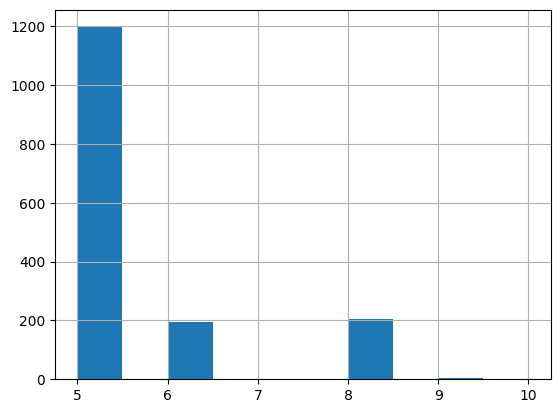

In [21]:
######## Show distribution of anger scores
print(results_df.anger_score.value_counts().sort_index())

results_df.anger_score.hist()

In [ ]:
############ Show the examples of complaints with different anger scores

# Adjust pandas display options to prevent clipping of long text
pd.set_option('display.max_colwidth', None)

# Group by anger_score and display one example complaint for each score
examples = results_df.groupby('anger_score').first()[['complaint']]
examples

,complaint
anger_score,
5.0,"The DSL internet service has been inconsistent lately, with frequent slowdowns during peak hours. This is making it difficult for my family to complete their tasks online."
6.0,"The internet service has been very inconsistent, with frequent outages and slow speeds, making it difficult to complete important tasks. This has been an ongoing issue despite being a loyal customer for 34 months."
7.0,"I have been charged a high monthly fee of $79.70, but the quality of service, particularly the streaming and internet speed, does not match the cost. It feels like I am overpaying for subpar services."
8.0,"The streaming TV service frequently buffers or crashes, making it impossible for me to watch anything without interruptions. This has been ongoing despite my high monthly charges, and I am very frustrated with the lack of reliability."
9.0,"I am extremely dissatisfied with the internet service. Despite paying consistently for 16 months, the connection has been slow and unreliable, and no meaningful assistance has been provided to resolve these issues."
10.0,"I have no access to any additional security features like OnlineSecurity, which makes me concerned about the safety of my connection. Why is this not offered or at least suggested as an option?"
